In [2]:
import cv2
import numpy as np
from numpy.lib.stride_tricks import as_strided
import os
import matplotlib.pyplot as plt

In [3]:
def _pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def _pad(X, k, padder=0):
    XX_shape = tuple(np.subtract(X.shape, k.shape) + 1)
    if XX_shape!=X.shape:
        P = np.subtract(X.shape, XX_shape) // 2
        if len(np.unique(P))!=1:
            print('kernel is not square matrix')
        else:
            X_ = np.pad(X, P[0], _pad_with, padder=padder)
    else:
        X_ = np.copy(X)
    return X_

def _dilation(X, k):
    X = ~(X.astype(bool)) * 1
    X_pad = _pad(X, k, padder=1)
    view_shape = tuple(np.subtract(X_pad.shape, k.shape) + 1) + k.shape
    strides = X_pad.strides + X_pad.strides
    sub_matrices = as_strided(X_pad, view_shape, strides) 
    cv = np.einsum('klij,ij->kl', sub_matrices, k)
    cv_ = cv // (k.shape[0] * k.shape[1]) 
    
    return ~(cv_.astype(bool)) * 1
    
def _erosion(X, k):
    X_pad = _pad(X, k)
    view_shape = tuple(np.subtract(X_pad.shape, k.shape) + 1) + k.shape
    strides = X_pad.strides + X_pad.strides
    sub_matrices = as_strided(X_pad, view_shape, strides) 
    cv = np.einsum('klij,ij->kl', sub_matrices, k)
    
    return cv // (k.shape[0] * k.shape[1])

def _conv2d(X, k):
    k_ = k / (k.shape[0] * k.shape[1])
    X_pad = _pad(X, k_)
    view_shape = tuple(np.subtract(X_pad.shape, k_.shape) + 1) + k_.shape
    strides = X_pad.strides + X_pad.strides
    sub_matrices = as_strided(X_pad, view_shape, strides) 
    cv = np.einsum('klij,ij->kl', sub_matrices, k_)
    return cv    

def gaussian_kernel(size, sigma):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g  

def _adpt_thold(image, kernel_size, c):
    sigma = 0.3 * ((kernel_size - 1) * 0.5 - 1) + 0.8
    k = gaussian_kernel(kernel_size, sigma=sigma)
    img_pad = _pad(image, k)
    view_shape = tuple(np.subtract(img_pad.shape, k.shape) + 1) + k.shape
    strides = img_pad.strides + img_pad.strides
    sub_matrices = as_strided(img_pad, view_shape, strides) 
    thold = np.einsum('klij,ij->kl', sub_matrices, k) - c
    img_adpt_thold = (~np.greater(image, thold)) / np.sum(k) * 1
    return img_adpt_thold

In [4]:
dP = './img'
sP = './result'

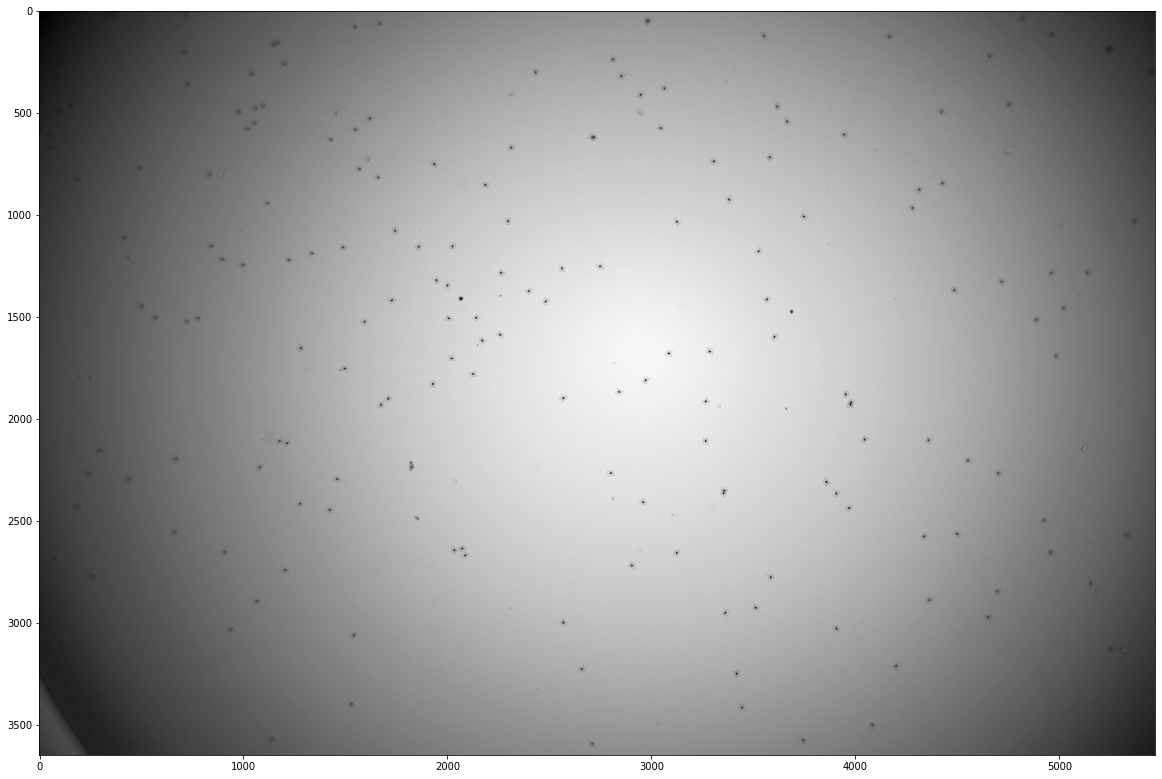

In [5]:
datalist = os.listdir(dP)
img_f = datalist[0]
image_org = cv2.imread(os.path.join(dP, img_f))
image = cv2.cvtColor(image_org, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(20, 20))
plt.imshow(image, cmap='gray')

## conv2d

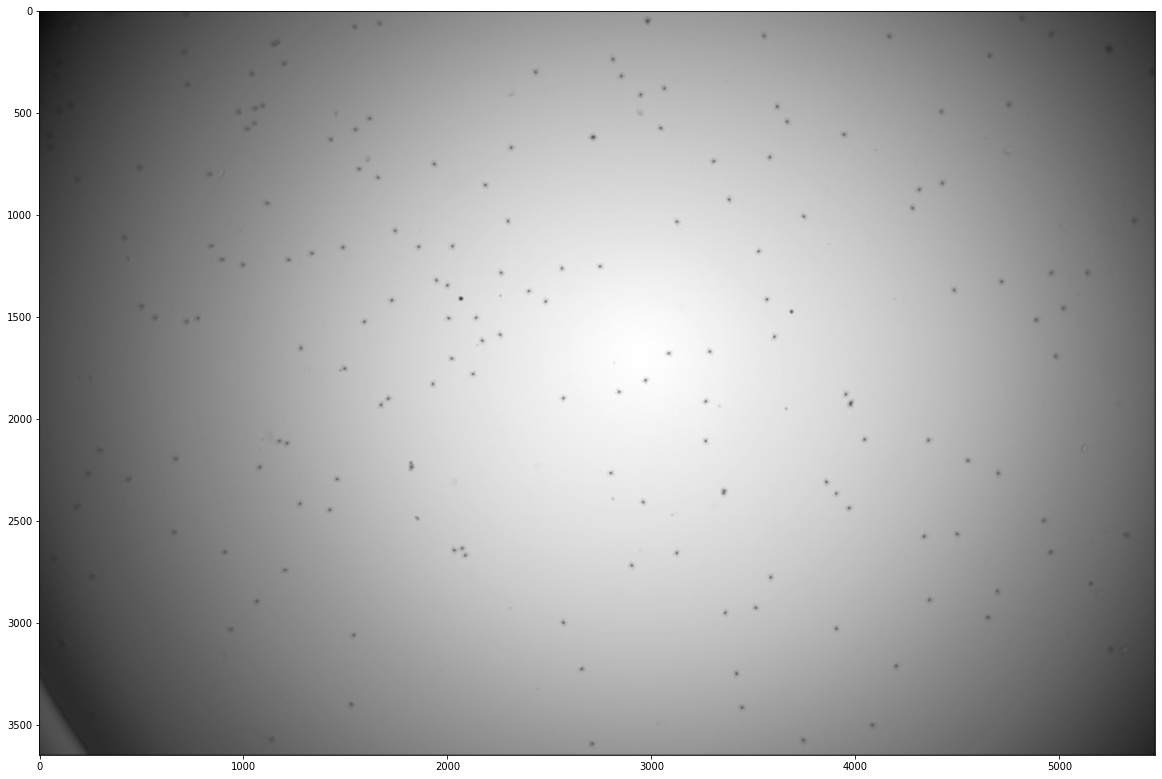

In [6]:
k = np.ones((11, 11))
img_cv = _conv2d(image, k)

fig = plt.figure(figsize=(20, 20))
plt.imshow(img_cv, cmap='gray')

## adpt_thold

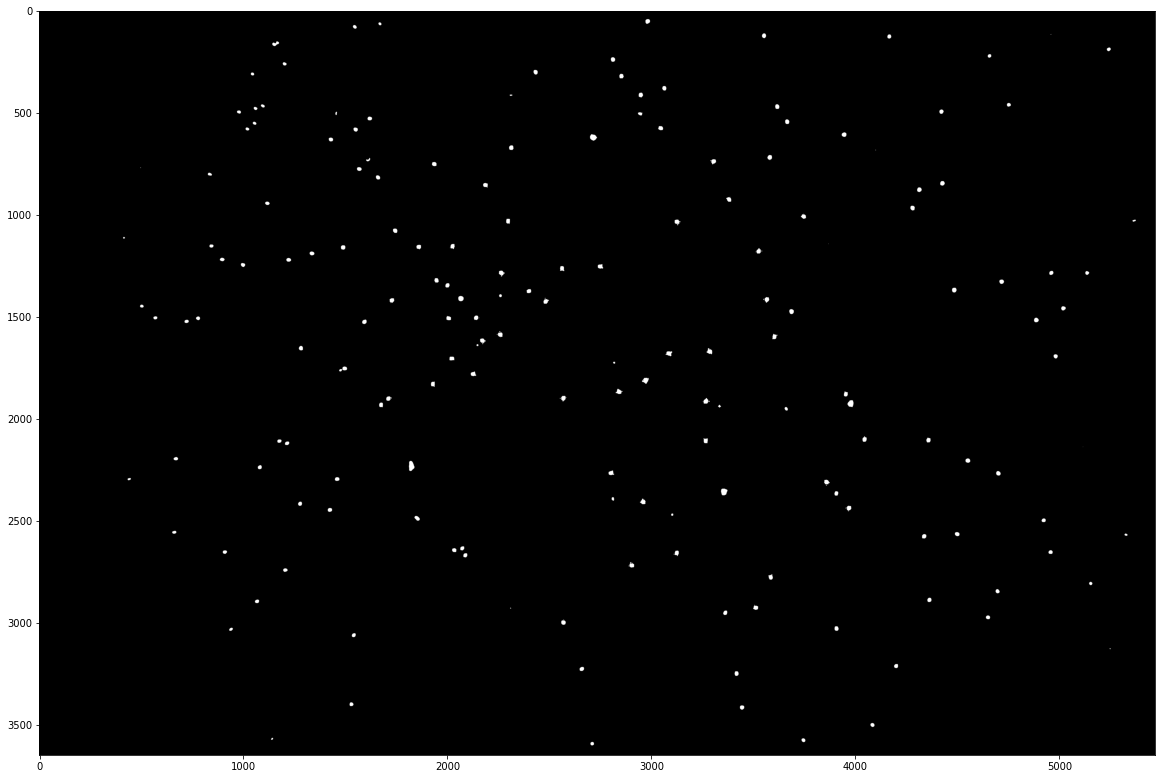

In [7]:
img_adpt_thold = _adpt_thold(img_cv, kernel_size=199, c=10)

fig = plt.figure(figsize=(20, 20))
plt.imshow(img_adpt_thold, cmap='gray')

## dilation

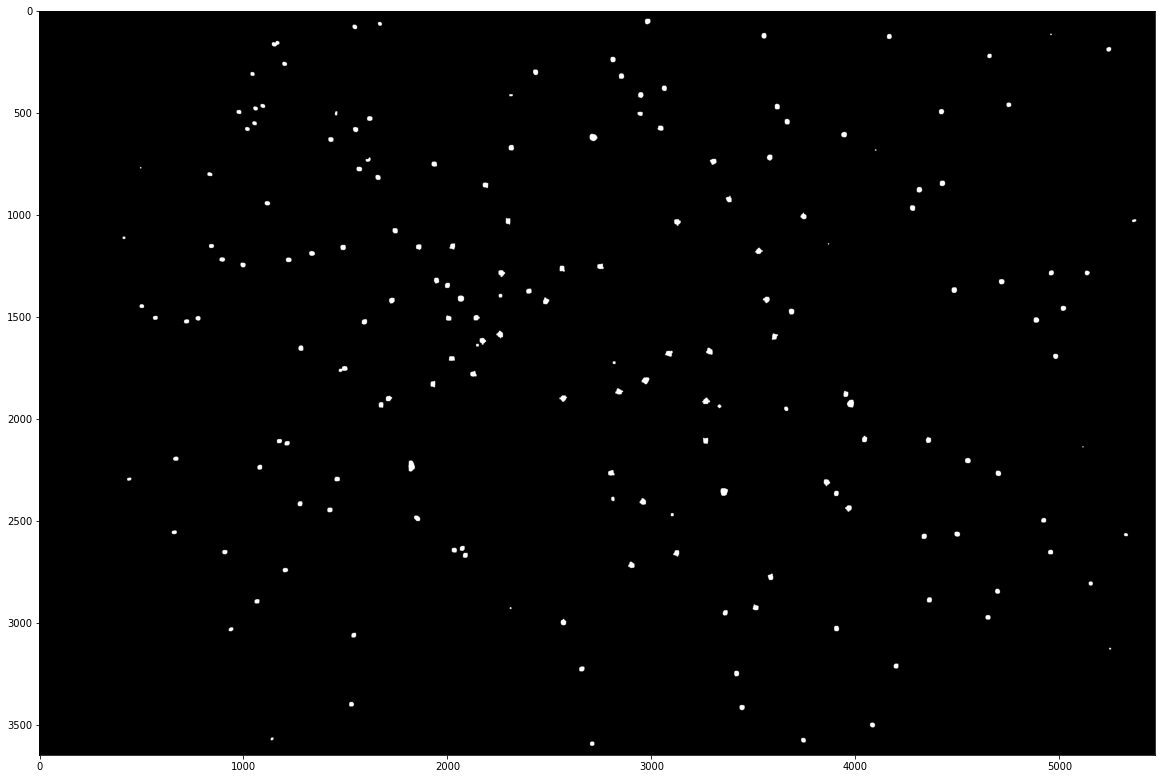

In [8]:
k = np.ones((5, 5))
img_d = _dilation(img_adpt_thold, k)
fig = plt.figure(figsize=(20, 20))
plt.imshow(img_d, cmap='gray')

## erosion

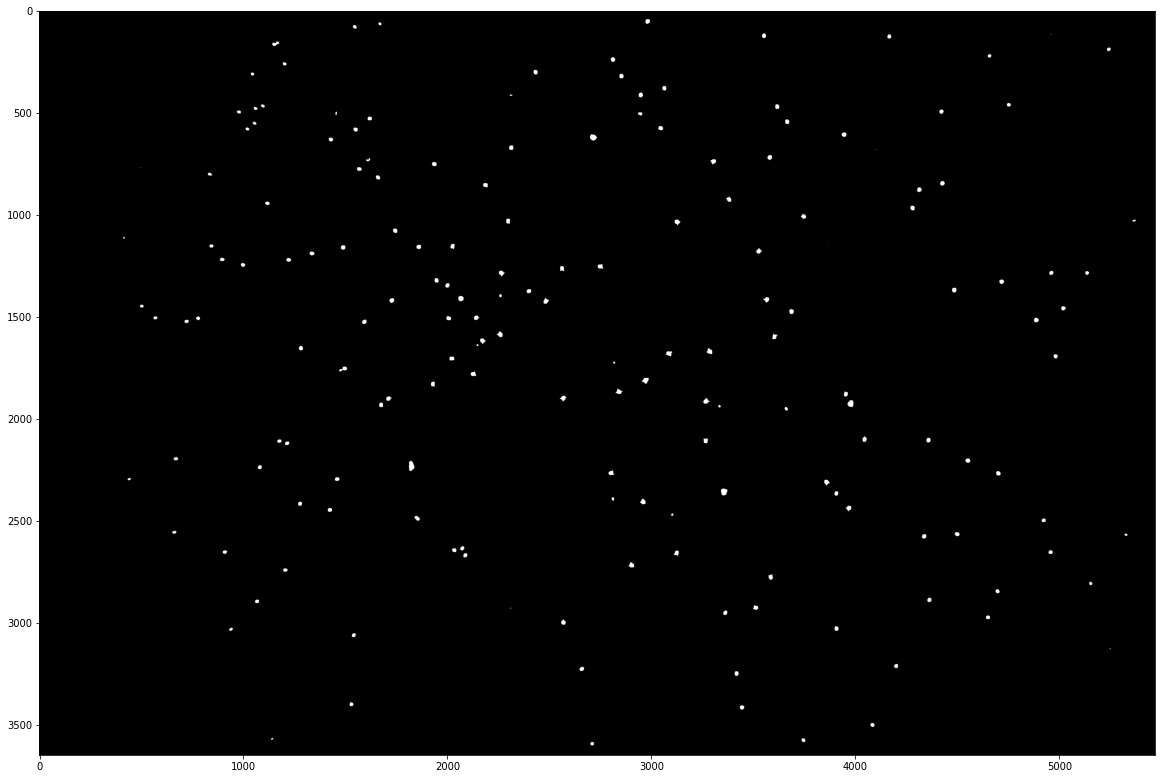

In [9]:
k = np.ones((5, 5))
img_e = _erosion(img_d, k)
fig = plt.figure(figsize=(20, 20))
plt.imshow(img_e, cmap='gray')

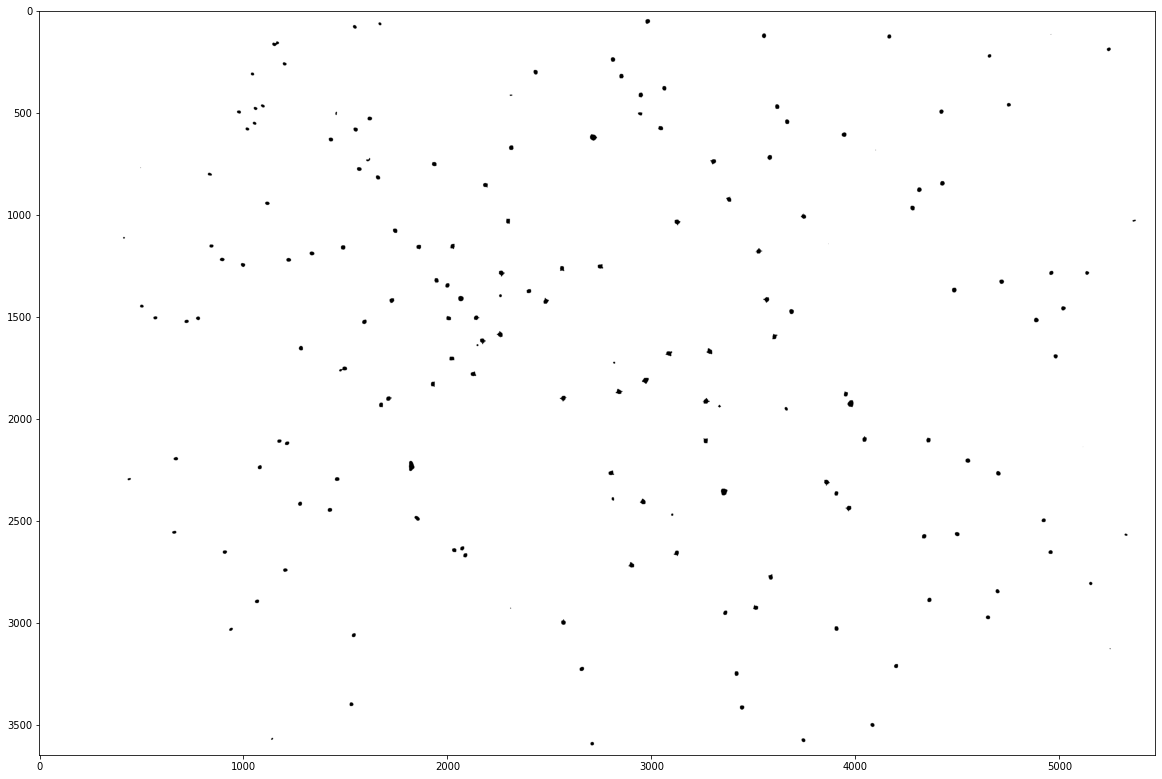

In [11]:
result = (~img_e.astype(bool)) * 255

fig = plt.figure(figsize=(20, 20))
plt.imshow(result, cmap='gray')